In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop, test_loop_random_start
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=123456789)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=10000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=100)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=1)
parser.add_argument('--sinkhorn-rounds', type=int, default=10)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=100, num_examples=524288, random_seed=123456789, rgt_start=0, rho=1, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=1, sinkhorn_rounds=10, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=10000)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds, marginal_choice='additive'
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [6]:
%%time
mean_rgt, mean_pay, lagr_mults = train_loop(model, train_loader, args, device=device)

  1%|          | 1/100 [00:35<58:43, 35.59s/it]

{'regret_max': 0.5104305148124695, 'regret_mean': 0.01336165051907301, 'regret_mults': tensor([[5.2996]], device='cuda:0'), 'payment': 0.31790098547935486}


  2%|▏         | 2/100 [01:11<58:05, 35.57s/it]

{'regret_max': 0.044741690158843994, 'regret_mean': 0.0047727106139063835, 'regret_mults': tensor([[5.6663]], device='cuda:0'), 'payment': 0.5475722551345825}


  3%|▎         | 3/100 [01:46<57:28, 35.55s/it]

{'regret_max': 0.03400546312332153, 'regret_mean': 0.0038250801153481007, 'regret_mults': tensor([[6.3693]], device='cuda:0'), 'payment': 0.5560887455940247}


  4%|▍         | 4/100 [02:21<56:43, 35.46s/it]

{'regret_max': 0.02084261178970337, 'regret_mean': 0.0029850718565285206, 'regret_mults': tensor([[7.7403]], device='cuda:0'), 'payment': 0.5589280128479004}


  5%|▌         | 5/100 [02:56<55:58, 35.35s/it]

{'regret_max': 0.017952561378479004, 'regret_mean': 0.002480330178514123, 'regret_mults': tensor([[9.0148]], device='cuda:0'), 'payment': 0.5594762563705444}


  6%|▌         | 6/100 [03:32<55:28, 35.41s/it]

{'regret_max': 0.01880824565887451, 'regret_mean': 0.002087125089019537, 'regret_mults': tensor([[10.3955]], device='cuda:0'), 'payment': 0.5576428174972534}


  7%|▋         | 7/100 [04:07<54:51, 35.39s/it]

{'regret_max': 0.01839315891265869, 'regret_mean': 0.0017459021182730794, 'regret_mults': tensor([[10.9865]], device='cuda:0'), 'payment': 0.5564524531364441}


  8%|▊         | 8/100 [04:43<54:16, 35.40s/it]

{'regret_max': 0.015387296676635742, 'regret_mean': 0.0016060021007433534, 'regret_mults': tensor([[12.0297]], device='cuda:0'), 'payment': 0.5553458333015442}


  9%|▉         | 9/100 [05:18<53:26, 35.24s/it]

{'regret_max': 0.016137421131134033, 'regret_mean': 0.0014323282521218061, 'regret_mults': tensor([[12.4560]], device='cuda:0'), 'payment': 0.5550813674926758}


 10%|█         | 10/100 [05:53<52:49, 35.22s/it]

{'regret_max': 0.014908313751220703, 'regret_mean': 0.001230649882927537, 'regret_mults': tensor([[13.6964]], device='cuda:0'), 'payment': 0.5552921295166016}


 11%|█         | 11/100 [06:28<52:20, 35.28s/it]

{'regret_max': 0.01654982566833496, 'regret_mean': 0.0013589116279035807, 'regret_mults': tensor([[15.6222]], device='cuda:0'), 'payment': 0.5524283051490784}


 12%|█▏        | 12/100 [07:04<51:45, 35.29s/it]

{'regret_max': 0.01408374309539795, 'regret_mean': 0.000876924954354763, 'regret_mults': tensor([[16.0259]], device='cuda:0'), 'payment': 0.5554117560386658}


 13%|█▎        | 13/100 [07:39<51:17, 35.37s/it]

{'regret_max': 0.015635371208190918, 'regret_mean': 0.0009012259542942047, 'regret_mults': tensor([[16.6306]], device='cuda:0'), 'payment': 0.5548021793365479}


 14%|█▍        | 14/100 [08:14<50:40, 35.36s/it]

{'regret_max': 0.016508042812347412, 'regret_mean': 0.0008268145611509681, 'regret_mults': tensor([[17.7131]], device='cuda:0'), 'payment': 0.5542415976524353}


 15%|█▌        | 15/100 [08:50<50:07, 35.38s/it]

{'regret_max': 0.013667643070220947, 'regret_mean': 0.0008174478425644338, 'regret_mults': tensor([[18.8348]], device='cuda:0'), 'payment': 0.553394079208374}


 16%|█▌        | 16/100 [09:26<49:39, 35.47s/it]

{'regret_max': 0.014191985130310059, 'regret_mean': 0.0007507211994379759, 'regret_mults': tensor([[19.3526]], device='cuda:0'), 'payment': 0.5534305572509766}


 17%|█▋        | 17/100 [10:01<48:55, 35.37s/it]

{'regret_max': 0.013994336128234863, 'regret_mean': 0.00073442846769467, 'regret_mults': tensor([[20.7737]], device='cuda:0'), 'payment': 0.5523799657821655}


 18%|█▊        | 18/100 [10:36<48:28, 35.47s/it]

{'regret_max': 0.01474672555923462, 'regret_mean': 0.0006384269800037146, 'regret_mults': tensor([[23.8240]], device='cuda:0'), 'payment': 0.5516132712364197}


 19%|█▉        | 19/100 [11:12<48:06, 35.64s/it]

{'regret_max': 0.015267372131347656, 'regret_mean': 0.0006552573177032173, 'regret_mults': tensor([[24.2107]], device='cuda:0'), 'payment': 0.5486582517623901}


 20%|██        | 20/100 [11:48<47:28, 35.61s/it]

{'regret_max': 0.013244271278381348, 'regret_mean': 0.0005735992453992367, 'regret_mults': tensor([[24.6028]], device='cuda:0'), 'payment': 0.5497193336486816}


 21%|██        | 21/100 [12:23<46:41, 35.47s/it]

{'regret_max': 0.014744758605957031, 'regret_mean': 0.0005512241623364389, 'regret_mults': tensor([[24.9807]], device='cuda:0'), 'payment': 0.5499008893966675}


 22%|██▏       | 22/100 [12:58<45:56, 35.33s/it]

{'regret_max': 0.013876199722290039, 'regret_mean': 0.0006158617325127125, 'regret_mults': tensor([[27.2296]], device='cuda:0'), 'payment': 0.5471259355545044}


 23%|██▎       | 23/100 [13:33<45:18, 35.31s/it]

{'regret_max': 0.015331506729125977, 'regret_mean': 0.0005387247074395418, 'regret_mults': tensor([[27.7311]], device='cuda:0'), 'payment': 0.547484278678894}


 24%|██▍       | 24/100 [14:09<44:39, 35.26s/it]

{'regret_max': 0.013811826705932617, 'regret_mean': 0.000521402689628303, 'regret_mults': tensor([[28.0871]], device='cuda:0'), 'payment': 0.5470339059829712}


 25%|██▌       | 25/100 [14:44<44:07, 35.30s/it]

{'regret_max': 0.015943288803100586, 'regret_mean': 0.0005287572275847197, 'regret_mults': tensor([[29.2172]], device='cuda:0'), 'payment': 0.5464740991592407}


 26%|██▌       | 26/100 [15:19<43:37, 35.38s/it]

{'regret_max': 0.015246748924255371, 'regret_mean': 0.0005305111408233643, 'regret_mults': tensor([[30.0548]], device='cuda:0'), 'payment': 0.5464332103729248}


 27%|██▋       | 27/100 [15:55<43:01, 35.36s/it]

{'regret_max': 0.01348423957824707, 'regret_mean': 0.00042139814468100667, 'regret_mults': tensor([[30.7968]], device='cuda:0'), 'payment': 0.5477330684661865}


 28%|██▊       | 28/100 [16:30<42:27, 35.39s/it]

{'regret_max': 0.014665007591247559, 'regret_mean': 0.0004357523284852505, 'regret_mults': tensor([[31.2080]], device='cuda:0'), 'payment': 0.5472484827041626}


 29%|██▉       | 29/100 [17:06<41:50, 35.36s/it]

{'regret_max': 0.014059960842132568, 'regret_mean': 0.00042807956924661994, 'regret_mults': tensor([[33.1969]], device='cuda:0'), 'payment': 0.5469014048576355}


 30%|███       | 30/100 [17:41<41:23, 35.48s/it]

{'regret_max': 0.015879929065704346, 'regret_mean': 0.00045810002484358847, 'regret_mults': tensor([[33.9220]], device='cuda:0'), 'payment': 0.5448600649833679}


 31%|███       | 31/100 [18:17<40:45, 35.44s/it]

{'regret_max': 0.01556175947189331, 'regret_mean': 0.00037727627204731107, 'regret_mults': tensor([[34.2918]], device='cuda:0'), 'payment': 0.5464911460876465}


 32%|███▏      | 32/100 [18:52<40:13, 35.49s/it]

{'regret_max': 0.014400780200958252, 'regret_mean': 0.0004052076837979257, 'regret_mults': tensor([[35.1979]], device='cuda:0'), 'payment': 0.546393096446991}


 33%|███▎      | 33/100 [19:27<39:31, 35.40s/it]

{'regret_max': 0.015527069568634033, 'regret_mean': 0.0003717320505529642, 'regret_mults': tensor([[36.5481]], device='cuda:0'), 'payment': 0.546455979347229}


 34%|███▍      | 34/100 [20:03<38:55, 35.38s/it]

{'regret_max': 0.014948546886444092, 'regret_mean': 0.00039833877235651016, 'regret_mults': tensor([[36.9143]], device='cuda:0'), 'payment': 0.5448839664459229}


 35%|███▌      | 35/100 [20:38<38:14, 35.30s/it]

{'regret_max': 0.013569056987762451, 'regret_mean': 0.00034481973852962255, 'regret_mults': tensor([[37.3656]], device='cuda:0'), 'payment': 0.5459703207015991}


 36%|███▌      | 36/100 [21:13<37:31, 35.18s/it]

{'regret_max': 0.015101313591003418, 'regret_mean': 0.00039996212581172585, 'regret_mults': tensor([[39.2886]], device='cuda:0'), 'payment': 0.5441389083862305}


 37%|███▋      | 37/100 [21:48<36:53, 35.14s/it]

{'regret_max': 0.014200687408447266, 'regret_mean': 0.0003658197238110006, 'regret_mults': tensor([[40.1728]], device='cuda:0'), 'payment': 0.544387936592102}


 38%|███▊      | 38/100 [22:23<36:10, 35.01s/it]

{'regret_max': 0.015427887439727783, 'regret_mean': 0.0003417613625060767, 'regret_mults': tensor([[41.4568]], device='cuda:0'), 'payment': 0.5444188714027405}


 39%|███▉      | 39/100 [22:58<35:40, 35.09s/it]

{'regret_max': 0.014544844627380371, 'regret_mean': 0.00032386480597779155, 'regret_mults': tensor([[42.0405]], device='cuda:0'), 'payment': 0.5447976589202881}


 40%|████      | 40/100 [23:33<35:01, 35.03s/it]

{'regret_max': 0.01579505205154419, 'regret_mean': 0.00033597974106669426, 'regret_mults': tensor([[45.3237]], device='cuda:0'), 'payment': 0.544127345085144}


 41%|████      | 41/100 [24:08<34:26, 35.03s/it]

{'regret_max': 0.013585269451141357, 'regret_mean': 0.00033388426527380943, 'regret_mults': tensor([[46.5827]], device='cuda:0'), 'payment': 0.5422646999359131}


 42%|████▏     | 42/100 [24:43<33:57, 35.13s/it]

{'regret_max': 0.013970911502838135, 'regret_mean': 0.0002830417361110449, 'regret_mults': tensor([[48.1390]], device='cuda:0'), 'payment': 0.5443800687789917}


 43%|████▎     | 43/100 [25:18<33:18, 35.06s/it]

{'regret_max': 0.014032721519470215, 'regret_mean': 0.00026724033523350954, 'regret_mults': tensor([[49.5459]], device='cuda:0'), 'payment': 0.5446399450302124}


 44%|████▍     | 44/100 [25:53<32:42, 35.04s/it]

{'regret_max': 0.014294028282165527, 'regret_mean': 0.0002603908651508391, 'regret_mults': tensor([[51.1977]], device='cuda:0'), 'payment': 0.5440308451652527}


 45%|████▌     | 45/100 [26:28<32:09, 35.09s/it]

{'regret_max': 0.014328539371490479, 'regret_mean': 0.00028263189597055316, 'regret_mults': tensor([[51.5165]], device='cuda:0'), 'payment': 0.5430910587310791}


 46%|████▌     | 46/100 [27:03<31:27, 34.96s/it]

{'regret_max': 0.014094352722167969, 'regret_mean': 0.00027157622389495373, 'regret_mults': tensor([[52.1406]], device='cuda:0'), 'payment': 0.5430690050125122}


 47%|████▋     | 47/100 [27:38<30:56, 35.03s/it]

{'regret_max': 0.014448940753936768, 'regret_mean': 0.0002621003077365458, 'regret_mults': tensor([[54.1691]], device='cuda:0'), 'payment': 0.542827844619751}


 48%|████▊     | 48/100 [28:13<30:22, 35.05s/it]

{'regret_max': 0.013132691383361816, 'regret_mean': 0.0002481475821696222, 'regret_mults': tensor([[54.8734]], device='cuda:0'), 'payment': 0.5429123044013977}


 49%|████▉     | 49/100 [28:48<29:48, 35.07s/it]

{'regret_max': 0.012149512767791748, 'regret_mean': 0.00024641412892378867, 'regret_mults': tensor([[56.0526]], device='cuda:0'), 'payment': 0.5434010028839111}


 50%|█████     | 50/100 [29:23<29:15, 35.10s/it]

{'regret_max': 0.01407545804977417, 'regret_mean': 0.00026238354621455073, 'regret_mults': tensor([[60.2018]], device='cuda:0'), 'payment': 0.5424521565437317}


 51%|█████     | 51/100 [29:59<28:41, 35.13s/it]

{'regret_max': 0.013879835605621338, 'regret_mean': 0.00024116295389831066, 'regret_mults': tensor([[61.2290]], device='cuda:0'), 'payment': 0.5418416261672974}


 52%|█████▏    | 52/100 [30:34<28:07, 35.16s/it]

{'regret_max': 0.014433979988098145, 'regret_mean': 0.00023567632888443768, 'regret_mults': tensor([[62.4542]], device='cuda:0'), 'payment': 0.5416527390480042}


 53%|█████▎    | 53/100 [31:09<27:33, 35.17s/it]

{'regret_max': 0.013128221035003662, 'regret_mean': 0.0002007895236602053, 'regret_mults': tensor([[62.7927]], device='cuda:0'), 'payment': 0.5419637560844421}


 54%|█████▍    | 54/100 [31:44<27:01, 35.25s/it]

{'regret_max': 0.012723922729492188, 'regret_mean': 0.00024574046256020665, 'regret_mults': tensor([[65.7704]], device='cuda:0'), 'payment': 0.5420764684677124}


 55%|█████▌    | 55/100 [32:19<26:20, 35.12s/it]

{'regret_max': 0.012396812438964844, 'regret_mean': 0.00019042225903831422, 'regret_mults': tensor([[66.7021]], device='cuda:0'), 'payment': 0.5417032241821289}


 56%|█████▌    | 56/100 [32:54<25:43, 35.08s/it]

{'regret_max': 0.012937009334564209, 'regret_mean': 0.0002595127443782985, 'regret_mults': tensor([[66.8802]], device='cuda:0'), 'payment': 0.539635181427002}


 57%|█████▋    | 57/100 [33:30<25:10, 35.12s/it]

{'regret_max': 0.011552810668945312, 'regret_mean': 0.0001716034603305161, 'regret_mults': tensor([[67.8341]], device='cuda:0'), 'payment': 0.5429143905639648}


 58%|█████▊    | 58/100 [34:05<24:37, 35.19s/it]

{'regret_max': 0.013156712055206299, 'regret_mean': 0.00023887254064902663, 'regret_mults': tensor([[70.0260]], device='cuda:0'), 'payment': 0.5406641364097595}


 59%|█████▉    | 59/100 [34:40<24:02, 35.19s/it]

{'regret_max': 0.011889278888702393, 'regret_mean': 0.0001916307955980301, 'regret_mults': tensor([[71.8148]], device='cuda:0'), 'payment': 0.5416593551635742}


 60%|██████    | 60/100 [35:15<23:30, 35.26s/it]

{'regret_max': 0.01233375072479248, 'regret_mean': 0.00018888921476900578, 'regret_mults': tensor([[72.7944]], device='cuda:0'), 'payment': 0.5413421988487244}


 61%|██████    | 61/100 [35:51<22:56, 35.30s/it]

{'regret_max': 0.013799428939819336, 'regret_mean': 0.00020993857469875365, 'regret_mults': tensor([[76.1521]], device='cuda:0'), 'payment': 0.5407245755195618}


 62%|██████▏   | 62/100 [36:26<22:22, 35.32s/it]

{'regret_max': 0.01220858097076416, 'regret_mean': 0.00016652833437547088, 'regret_mults': tensor([[76.6918]], device='cuda:0'), 'payment': 0.5406938791275024}


 63%|██████▎   | 63/100 [37:02<21:47, 35.33s/it]

{'regret_max': 0.012713909149169922, 'regret_mean': 0.00020464451517909765, 'regret_mults': tensor([[77.0273]], device='cuda:0'), 'payment': 0.5407668352127075}


 64%|██████▍   | 64/100 [37:37<21:10, 35.30s/it]

{'regret_max': 0.014393031597137451, 'regret_mean': 0.00020210603543091565, 'regret_mults': tensor([[79.9660]], device='cuda:0'), 'payment': 0.5399638414382935}


 65%|██████▌   | 65/100 [38:12<20:31, 35.18s/it]

{'regret_max': 0.0124550461769104, 'regret_mean': 0.0001657232642173767, 'regret_mults': tensor([[80.8927]], device='cuda:0'), 'payment': 0.5407050848007202}


 66%|██████▌   | 66/100 [38:47<19:56, 35.18s/it]

{'regret_max': 0.012319087982177734, 'regret_mean': 0.00014670364907942712, 'regret_mults': tensor([[81.3923]], device='cuda:0'), 'payment': 0.5415184497833252}


 67%|██████▋   | 67/100 [39:22<19:22, 35.23s/it]

{'regret_max': 0.011938095092773438, 'regret_mean': 0.00020508168381638825, 'regret_mults': tensor([[81.6504]], device='cuda:0'), 'payment': 0.5410202145576477}


 68%|██████▊   | 68/100 [39:58<18:48, 35.26s/it]

{'regret_max': 0.01338130235671997, 'regret_mean': 0.00016259585390798748, 'regret_mults': tensor([[85.9855]], device='cuda:0'), 'payment': 0.5405045747756958}


 69%|██████▉   | 69/100 [40:32<18:06, 35.05s/it]

{'regret_max': 0.011585533618927002, 'regret_mean': 0.00012592028360813856, 'regret_mults': tensor([[86.7322]], device='cuda:0'), 'payment': 0.5415458679199219}


 70%|███████   | 70/100 [41:07<17:31, 35.05s/it]

{'regret_max': 0.01311880350112915, 'regret_mean': 0.00019037158926948905, 'regret_mults': tensor([[87.1047]], device='cuda:0'), 'payment': 0.5398128032684326}


 71%|███████   | 71/100 [41:42<16:52, 34.90s/it]

{'regret_max': 0.012138664722442627, 'regret_mean': 0.00015947333304211497, 'regret_mults': tensor([[87.5841]], device='cuda:0'), 'payment': 0.5401378870010376}


 72%|███████▏  | 72/100 [42:16<16:13, 34.77s/it]

{'regret_max': 0.01449209451675415, 'regret_mean': 0.00024570204550400376, 'regret_mults': tensor([[90.1847]], device='cuda:0'), 'payment': 0.5366724729537964}


 73%|███████▎  | 73/100 [42:51<15:38, 34.76s/it]

{'regret_max': 0.01395958662033081, 'regret_mean': 0.0001448231632821262, 'regret_mults': tensor([[91.7421]], device='cuda:0'), 'payment': 0.5386400818824768}


 74%|███████▍  | 74/100 [43:26<15:06, 34.85s/it]

{'regret_max': 0.012952089309692383, 'regret_mean': 0.00015166489174589515, 'regret_mults': tensor([[92.7066]], device='cuda:0'), 'payment': 0.5399786233901978}


 75%|███████▌  | 75/100 [44:01<14:31, 34.85s/it]

{'regret_max': 0.012034416198730469, 'regret_mean': 0.00013358582509681582, 'regret_mults': tensor([[93.6469]], device='cuda:0'), 'payment': 0.5396857261657715}


 76%|███████▌  | 76/100 [44:36<13:55, 34.80s/it]

{'regret_max': 0.012433946132659912, 'regret_mean': 0.00012439336569514126, 'regret_mults': tensor([[93.9138]], device='cuda:0'), 'payment': 0.5404707193374634}


 77%|███████▋  | 77/100 [45:10<13:20, 34.81s/it]

{'regret_max': 0.012456357479095459, 'regret_mean': 0.00017997901886701584, 'regret_mults': tensor([[94.2893]], device='cuda:0'), 'payment': 0.5390456318855286}


 78%|███████▊  | 78/100 [45:45<12:44, 34.77s/it]

{'regret_max': 0.011864721775054932, 'regret_mean': 0.0001478761259932071, 'regret_mults': tensor([[97.1005]], device='cuda:0'), 'payment': 0.538840651512146}


 79%|███████▉  | 79/100 [46:19<12:07, 34.66s/it]

{'regret_max': 0.013063907623291016, 'regret_mean': 0.0001707518968032673, 'regret_mults': tensor([[99.1225]], device='cuda:0'), 'payment': 0.5379635691642761}


 80%|████████  | 80/100 [46:55<11:36, 34.81s/it]

{'regret_max': 0.013184607028961182, 'regret_mean': 0.00013328461500350386, 'regret_mults': tensor([[99.4887]], device='cuda:0'), 'payment': 0.5390032529830933}


 81%|████████  | 81/100 [47:29<11:01, 34.83s/it]

{'regret_max': 0.012548208236694336, 'regret_mean': 0.00013213859347160906, 'regret_mults': tensor([[99.8357]], device='cuda:0'), 'payment': 0.5384242534637451}


 82%|████████▏ | 82/100 [48:04<10:23, 34.66s/it]

{'regret_max': 0.011961817741394043, 'regret_mean': 0.0001908991689560935, 'regret_mults': tensor([[100.0819]], device='cuda:0'), 'payment': 0.5366837978363037}


 83%|████████▎ | 83/100 [48:38<09:46, 34.53s/it]

{'regret_max': 0.013384401798248291, 'regret_mean': 0.00013201389811001718, 'regret_mults': tensor([[101.7338]], device='cuda:0'), 'payment': 0.5387765169143677}


 84%|████████▍ | 84/100 [49:13<09:12, 34.55s/it]

{'regret_max': 0.010995328426361084, 'regret_mean': 0.00010599115921650082, 'regret_mults': tensor([[102.0817]], device='cuda:0'), 'payment': 0.540064811706543}


 85%|████████▌ | 85/100 [49:47<08:39, 34.65s/it]

{'regret_max': 0.012490391731262207, 'regret_mean': 0.0001756552082952112, 'regret_mults': tensor([[102.5787]], device='cuda:0'), 'payment': 0.5383120775222778}


 86%|████████▌ | 86/100 [50:22<08:06, 34.76s/it]

{'regret_max': 0.012885689735412598, 'regret_mean': 0.0001165478170150891, 'regret_mults': tensor([[103.1255]], device='cuda:0'), 'payment': 0.5391078591346741}


 87%|████████▋ | 87/100 [50:57<07:32, 34.80s/it]

{'regret_max': 0.014695405960083008, 'regret_mean': 0.0001517976343166083, 'regret_mults': tensor([[103.6387]], device='cuda:0'), 'payment': 0.5378319621086121}


 88%|████████▊ | 88/100 [51:32<06:56, 34.67s/it]

{'regret_max': 0.013064384460449219, 'regret_mean': 0.0001310391817241907, 'regret_mults': tensor([[104.3124]], device='cuda:0'), 'payment': 0.5388464331626892}


 89%|████████▉ | 89/100 [52:06<06:21, 34.68s/it]

{'regret_max': 0.012223660945892334, 'regret_mean': 0.00014348412514664233, 'regret_mults': tensor([[104.9470]], device='cuda:0'), 'payment': 0.5381180644035339}


 90%|█████████ | 90/100 [52:41<05:47, 34.72s/it]

{'regret_max': 0.012182891368865967, 'regret_mean': 0.00011099636321887374, 'regret_mults': tensor([[106.2580]], device='cuda:0'), 'payment': 0.5399459600448608}


 91%|█████████ | 91/100 [53:16<05:12, 34.71s/it]

{'regret_max': 0.011371254920959473, 'regret_mean': 0.00012715670163743198, 'regret_mults': tensor([[108.6542]], device='cuda:0'), 'payment': 0.5391669869422913}


 92%|█████████▏| 92/100 [53:51<04:37, 34.74s/it]

{'regret_max': 0.012405037879943848, 'regret_mean': 0.00012376293307170272, 'regret_mults': tensor([[108.9525]], device='cuda:0'), 'payment': 0.5387012958526611}


 93%|█████████▎| 93/100 [54:25<04:03, 34.74s/it]

{'regret_max': 0.011068642139434814, 'regret_mean': 0.00014912552433088422, 'regret_mults': tensor([[110.4416]], device='cuda:0'), 'payment': 0.538123369216919}


 94%|█████████▍| 94/100 [55:00<03:28, 34.81s/it]

{'regret_max': 0.012530803680419922, 'regret_mean': 0.00011413703032303602, 'regret_mults': tensor([[110.7216]], device='cuda:0'), 'payment': 0.5377782583236694}


 95%|█████████▌| 95/100 [55:35<02:54, 34.81s/it]

{'regret_max': 0.01283961534500122, 'regret_mean': 0.00014694634592160583, 'regret_mults': tensor([[111.1379]], device='cuda:0'), 'payment': 0.5379136800765991}


 96%|█████████▌| 96/100 [56:10<02:19, 34.76s/it]

{'regret_max': 0.012085556983947754, 'regret_mean': 0.0001118918153224513, 'regret_mults': tensor([[111.4545]], device='cuda:0'), 'payment': 0.5393036603927612}


 97%|█████████▋| 97/100 [56:45<01:44, 34.78s/it]

{'regret_max': 0.011505603790283203, 'regret_mean': 0.00012752543261740357, 'regret_mults': tensor([[112.5318]], device='cuda:0'), 'payment': 0.5383288264274597}


 98%|█████████▊| 98/100 [57:19<01:09, 34.76s/it]

{'regret_max': 0.012946128845214844, 'regret_mean': 0.00013402692275121808, 'regret_mults': tensor([[112.7756]], device='cuda:0'), 'payment': 0.5377220511436462}


 99%|█████████▉| 99/100 [57:54<00:34, 34.63s/it]

{'regret_max': 0.013301372528076172, 'regret_mean': 0.0001504534884588793, 'regret_mults': tensor([[113.1682]], device='cuda:0'), 'payment': 0.5364706516265869}


100%|██████████| 100/100 [58:29<00:00, 35.09s/it]

{'regret_max': 0.012470424175262451, 'regret_mean': 9.744289855007082e-05, 'regret_mults': tensor([[113.7045]], device='cuda:0'), 'payment': 0.5380468368530273}
CPU times: user 58min 14s, sys: 11.3 s, total: 58min 26s
Wall time: 58min 29s


In [7]:
dir_name = 'additive_1x2_0_1_experiment_data/'
test_data = torch.load(dir_name + 'test_data')

In [8]:
%%time

# test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)

test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

1it [00:19, 19.99s/it]

CPU times: user 19.9 s, sys: 62 ms, total: 20 s
Wall time: 20 s


{'payment_mean': 0.5442991256713867,
 'regret_mean': 0.0011230985401198268,
 'regret_max': 0.01163548231124878}

In [9]:
def additive_1x2_0_1_optimal_mechanism(bids):
    import math
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((bids.shape[0], bids.shape[1]))
    for i in range(bids.shape[0]):
        if bids[i, :, 0] > (2 / 3) and bids[i, :, 1] < (2 - math.sqrt(2)) / 3:
            allocs[i, 0, :] = torch.tensor([1, 0])
            payments[i, :] = 2 / 3
        elif bids[i, :, 1] > (2 / 3) and bids[i, :, 0] < (2 - math.sqrt(2)) / 3:
            allocs[i, 0, :] = torch.tensor([0, 1])
            payments[i, :] = 2 / 3
        elif (2 - math.sqrt(2)) / 3 - bids[i, :, 0] < bids[i, 0, 1] - 2 / 3:
            allocs[i, 0, :] = torch.tensor([1, 1])
            payments[i, :] = 4 / 3 - math.sqrt(2) / 3
    return allocs, payments

opt_alloc, opt_payments = additive_1x2_0_1_optimal_mechanism(test_data)
opt_payments.mean()

tensor(0.5570)

In [10]:
%%time
args.test_num_examples = 1000
args.test_batch_size = 1000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
# model.sinkhorn_rounds = 20
# model.sinkhorn_epsilon = 1e-1

random_starts = [test_data]
for i in range(10):
    random_starts.append(ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device))
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
result

1it [01:50, 110.42s/it]

CPU times: user 1min 49s, sys: 364 ms, total: 1min 50s
Wall time: 1min 50s


{'payment_mean': 0.5442991256713867,
 'regret_mean': 0.0015487802447751164,
 'regret_max': 0.01179438829421997}

In [11]:
model.save(dir_name)

In [12]:
cpu_model = DoubleNet.load(dir_name).to(device='cpu')

In [13]:
def plot_12_model(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    import math
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_allocs = output_allocs[:, :, 0].view(xlen, ylen)
    output_item2_allocs = output_allocs[:, :, 1].view(xlen, ylen)
    f, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(output_item1_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax1.set_title('prob of allocating item 1')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    im2 = ax2.imshow(output_item2_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax2.set_title('prob of allocating item 2')
    ax2.set_xlabel('v1')
    ax2.set_ylabel('v2')
    
    f.colorbar(im1, ax=ax1)
    f.colorbar(im2, ax=ax2)
    f.tight_layout()
    f.show()

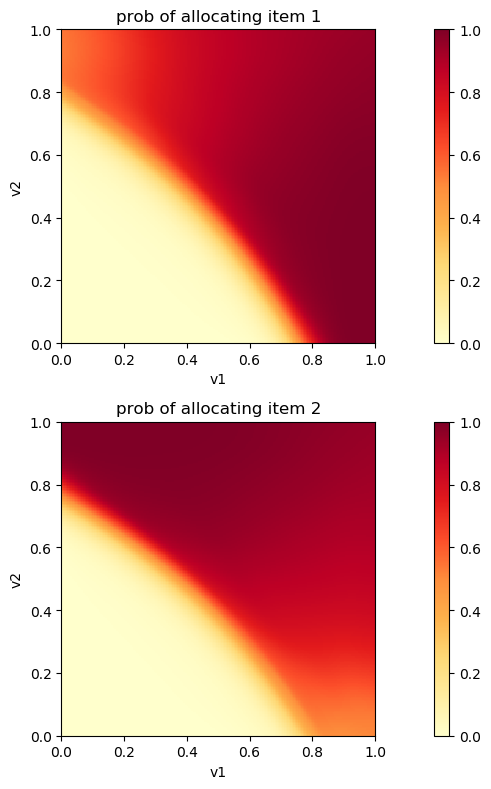

In [14]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
# cpu_model.sinkhorn_rounds = 100
# cpu_model.sinkhorn_epsilon = 1e-1
plot_12_model(cpu_model, 0.005, (0,1), (0,1))

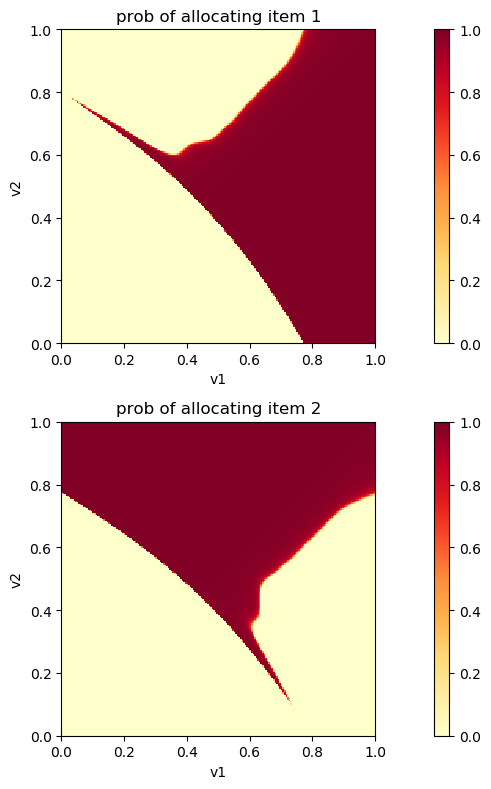

In [15]:
cpu_model.sinkhorn_rounds = 100
cpu_model.sinkhorn_epsilon = 1e-2
plot_12_model(cpu_model, 0.005, (0,1), (0,1))

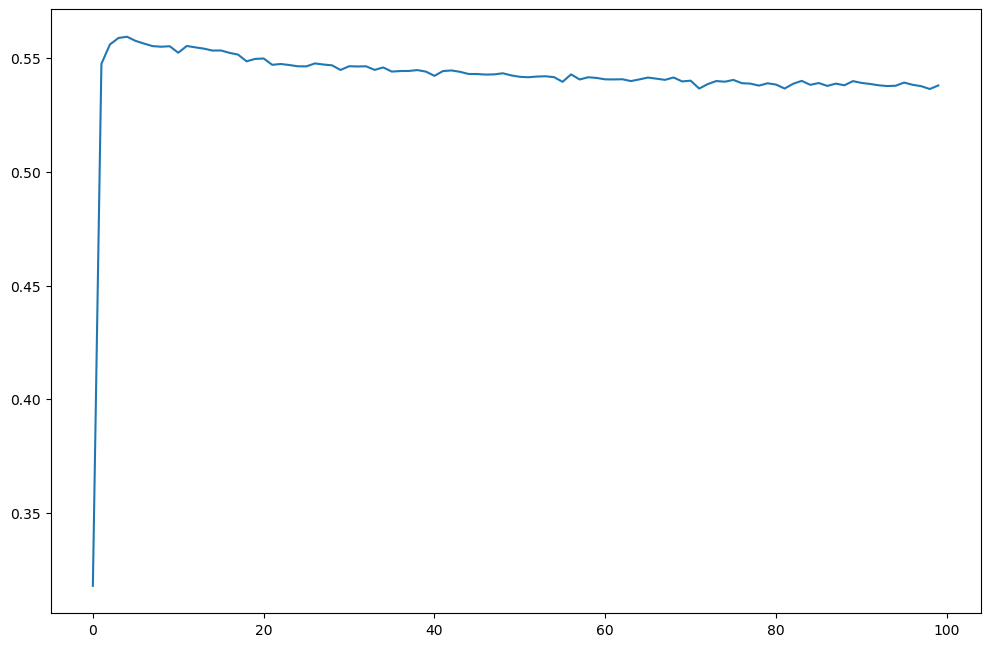

In [16]:
import matplotlib.pyplot as plt
plt.plot(mean_pay)

In [17]:
import pickle
to_pkl_lst = [mean_rgt, mean_pay, lagr_mults]
for i, fname in enumerate(['mean_rgt', 'mean_pay', 'lagr_mults']):
    with open(dir_name + fname, 'wb') as fp:
        pickle.dump(to_pkl_lst[i], fp)